## ***Reinforcement Learning - 2024***
*Laboratorio 6*
Stefano Aragoni, Carol Arévalo, Luis Santos
____________________


### **TASK 1**
Responda a cada de las siguientes preguntas de forma clara y lo más completamente posible.


**1. ¿Qué es Prioritized sweeping para ambientes determinísticos?**

Prioritized sweeping es un algoritmo de planificación que se utiliza para encontrar la política óptima en un ambiente determinístico. Este algoritmo se basa en la idea de que las transiciones que tienen un mayor impacto en la política óptima son las que se deben priorizar. Para ello, se utiliza una cola de prioridad que se va actualizando a medida que se van explorando las transiciones del ambiente. De esta forma, se garantiza que las transiciones más importantes se exploren primero, lo que permite encontrar la política óptima de forma más eficiente.


**2. ¿Qué es Trajectory Sampling?**

Trajectory Sampling es un método de aprendizaje por refuerzo que se utiliza para estimar la función de valor de un estado a partir de las trayectorias de un agente en un ambiente. En este método, se generan múltiples trayectorias de un agente en el ambiente y se utilizan para estimar la función de valor de los estados visitados por el agente. De esta forma, se obtiene una estimación de la función de valor que se puede utilizar para mejorar la política del agente.


**3. ¿Qué es Upper Confidence Bounds para Árboles (UCT por sus siglas en inglés)?**

Upper Confidence Bounds para Árboles (UCT) es un algoritmo de búsqueda que se utiliza para encontrar la mejor acción a tomar en un árbol de búsqueda. Este algoritmo se basa en la idea de que se deben explorar las acciones que tienen un mayor potencial de mejorar la política del agente. Para ello, se utiliza una función de valor que combina la estimación de la recompensa de una acción con la incertidumbre asociada a esa estimación. De esta forma, se garantiza que se exploren las acciones que tienen un mayor potencial de mejorar la política del agente.


___
### **TASK 2**

En este laboratorio, compararán el rendimiento de Dyna-Q+ y MCTS, dos de los algoritmos que vimos en clase, utilizando el entorno de FrozenLake-v1 de la biblioteca Gymnasium. Analizará y graficará las recompensas por episodio y responderá las preguntas que aparecen al final para asegurar su comprensión de los algoritmos.

### 1. Implementación de MCTS

Entendido, te proporciono una explicación revisada de cada punto sin indicar la repetición, con detalles adicionales donde sea relevante:

**a. Implemente un algoritmo de búsqueda de árbol de Monte Carlo (MCTS) para resolver el entorno FrozenLake-v1.**
- **Implementación**: La clase `MCTS` implementa el algoritmo MCTS completo, donde el método `Search` realiza el proceso iterativo de búsqueda. Esta búsqueda incluye selección de nodos basada en la métrica UCB1, expansión de nodos, simulación de resultados de acciones y retropropagación de las recompensas obtenidas.

**b. Use una estructura de árbol para simular diferentes secuencias de acciones a partir del estado actual.**
- **Implementación**: Utilizando la clase `Node`, cada estado del juego se representa como un nodo en un árbol. Cada nodo puede tener varios nodos hijos, cada uno representando un estado posible después de tomar una acción específica desde el estado actual.

**c. Para cada secuencia de acciones simulada, implemente una política en un estado terminal, acumule recompensas y propague estas recompensas a través del árbol.**
- **Implementación**: Después de alcanzar un estado terminal durante la simulación (método `Simulate`), se acumulan las recompensas obtenidas. Estas recompensas se propagan hacia atrás hasta la raíz del árbol mediante el método `Backpropagate`, actualizando el conteo de visitas y la suma de recompensas de cada nodo involucrado.

**d. Seleccione acciones en función de las rutas más prometedoras descubiertas durante la búsqueda.**
- **Implementación**: La selección de nodos para expansión se basa en el valor UCB1 calculado, que favorece los nodos con alto rendimiento promedio y aquellos menos explorados, buscando el equilibrio entre explotar rutas conocidas y explorar nuevas posibilidades.

**e. Considere usar límites de confianza superior para árboles (UCT) para equilibrar la exploración y la explotación en su búsqueda.**
- **Implementación**: La fórmula UCB1 integra tanto el rendimiento promedio del nodo (explotación) como un término que crece con la raíz del logaritmo del número total de visitas al padre dividido por el número de visitas al nodo (exploración). Esta fórmula ayuda a decidir cuándo explorar nuevos caminos potencialmente prometedores frente a seguir explotando los ya conocidos.

**f. Implemente un algoritmo de búsqueda de árbol de Monte Carlo (MCTS) para resolver el entorno FrozenLake-v1.**
- **Implementación**: El proceso de búsqueda en `MCTS` inicia con la creación de un nodo raíz y luego itera a través de las etapas de selección, expansión, simulación y retropropagación, permitiendo que el árbol de búsqueda crezca y refine las estimaciones de las mejores acciones posibles desde el estado inicial.

**g. Use una estructura de árbol para simular diferentes secuencias de acciones a partir del estado actual.**
- **Implementación **: La estructura del árbol permite simular trayectorias completas dentro del ambiente estocástico de FrozenLake-v1, evaluando las consecuencias de secuencias de acciones a partir de cualquier estado del juego reflejado en el árbol.

**h. Para cada secuencia de acciones simulada, implemente una política en un estado terminal, acumule recompensas y propague estas recompensas a través del árbol.**
- **Implementación**: Al final de cada simulación, la política aleatoria determina las acciones hasta alcanzar un estado terminal, momento en el cual las recompensas acumuladas proporcionan una medida de la efectividad de la secuencia de acciones tomadas. La retropropagación ajusta los parámetros estadísticos de cada nodo para reflejar su potencial basado en los resultados acumulados.

**i. Seleccione acciones en función de las rutas más prometedoras descubiertas durante la búsqueda.**
- **Implementación**: La selección y expansión continuas ajustan dinámicamente el foco de la búsqueda en el árbol, permitiendo que el algoritmo identifique y explore más a fondo las rutas que consistentemente muestran un alto rendimiento en términos de recompensas.

**j. Considere usar límites de confianza superior para árboles (UCT) para equilibrar la exploración y la explotación en su búsqueda.**
- **Implementación**: El uso de UCB1 como una guía para la selección de acciones asegura que el algoritmo de MCTS no se estanque en un localismo, pero tampoco desperdicie recursos explorando opciones claramente no rentables, logrando un compromiso entre seguridad y riesgo calculado.

**k. Consideración especial: FrozenLake-v1 tiene dinámica estocástica, lo que significa que las transiciones son probabilísticas. Asegúrese de que su implementación de MCTS maneje estas transiciones probabilísticas de manera adecuada.**
- **Consideraciones Adicionales**: El método `Simulate` utiliza acciones aleatorias, por lo que se manejar adecuadamente la incertidumbre y la variabilidad del ambiente. Este enfoque garantiza que el modelo pueda adaptarse y responder a diferentes resultados posibles a partir de un mismo estado.

In [17]:
import numpy as np
import gym
import random
from math import sqrt, log

In [18]:
class Node:
    def __init__(self, state, parent=None):
        self.state = state            # Estado actual del nodo
        self.parent = parent          # Nodo padre
        self.children = []            # Lista de nodos hijos
        self.visits = 0               # Contador de visitas al nodo
        self.wins = 0                 # Contador de victorias acumuladas

    def AddChild(self, child_state):
        child_node = Node(child_state, parent=self)  # Crea un nuevo nodo hijo
        self.children.append(child_node)             # Añade el hijo a la lista de hijos
        return child_node

    def UCB1(self, exploration_weight=1.41):
        if self.visits == 0:                                                                                 # Si no ha sido visitado, devuelve infinito
            return float('inf')
        return (self.wins / self.visits) + exploration_weight * sqrt(log(self.parent.visits) / self.visits)  # Calcula el valor UCB1 para equilibrar explotación y exploración


In [19]:
class MCTS:
    def __init__(self, env, max_iterations=1000):
        self.env = env                                # Ambiente de Gym
        self.max_iterations = max_iterations          # Máximo de iteraciones

    def Search(self, root):
        for _ in range(self.max_iterations):          # Bucle de búsqueda
            node = self.Select(root)                  # Selección de nodo
            reward = self.Simulate(node.state)        # Simulación desde el estado
            self.Backpropagate(node, reward)          # Propagación de recompensas

    def Select(self, node):
        while node.children:                                   # Mientras hay hijos
            node = max(node.children, key=lambda n: n.UCB1())  # Selecciona el mejor hijo
        return self.Expand(node)                               # Expande el nodo seleccionado

    def Expand(self, node):
        actions = range(self.env.action_space.n)                    # Obtiene posibles acciones
        for action in actions:
            next_state, reward, done, _, _ = self.env.step(action)  # Realiza la acción
            if not done:                                            # Si no es terminal, añade el hijo
                child_node = node.AddChild(next_state)
        return node                                                 # Retorna el nodo expandido

    def Simulate(self, state):
        total_reward = 0
        self.env.reset()
        self.env.env.s = state                                      # Establece el estado actual
        done = False
        while not done:
            action = self.env.action_space.sample()                 # Selecciona una acción al azar
            next_state, reward, done, _, _ = self.env.step(action)
            total_reward += reward                                  # Acumula recompensas
        return total_reward

    def Backpropagate(self, node, reward):
        while node is not None:
            node.visits += 1                          # Incrementa las visitas
            node.wins += reward                       # Acumula las victorias
            node = node.parent                        # Sube al nodo padre


In [20]:
def RunMCTS(envName, max_iterations):
    env = gym.make(envName)                           # Crea el ambiente
    initial_state = env.reset()                       # Estado inicial
    root = Node(initial_state)                        # Nodo raíz
    mcts = MCTS(env, max_iterations)
    mcts.Search(root)                                 # Inicia la búsqueda

    # Encuentra la mejor acción basada en las visitas
    if root.children:
        best_node = max(root.children, key=lambda n: n.visits)
        return best_node.state
    else:
        print("No children found, cannot determine the best action.")
        return None

result = RunMCTS("FrozenLake-v1", 1000)
print("Estado final alcanzado:", result)

Estado final alcanzado: 4


#### 2. Implementación de Dyna-Q+

In [22]:
class DynaQPlus:
    def __init__(self, env, numEpisodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1, planningSteps=10):
        self.env = env                                # Ambiente de Gym
        self.numEpisodes = numEpisodes                # Número de episodios para entrenamiento
        self.alpha = alpha                            # Tasa de aprendizaje
        self.gamma = gamma                            # Factor de descuento
        self.epsilon = epsilon                        # Probabilidad de exploración
        self.planningSteps = planningSteps            # Número de pasos de planificación
        self.qTable = np.zeros((env.observation_space.n, env.action_space.n))  # Tabla Q inicializada
        self.model = {}                               # Modelo para almacenar transiciones

    def ChooseAction(self, state):
        if random.random() < self.epsilon:            # Decisión de explorar o explotar
            return self.env.action_space.sample()     # Explorar: acción aleatoria
        else:
            return np.argmax(self.qTable[state])      # Explotar: mejor acción conocida

    def UpdateModel(self, state, action, reward, nextState):
        self.model[(state, action)] = (reward, nextState)             # Actualizar el modelo con la transición

    def Plan(self):
        for _ in range(self.planningSteps):                           # Realizar pasos de planificación
            stateActionPair = random.choice(list(self.model.keys()))  # Escoger par estado-acción aleatorio
            state, action = stateActionPair
            reward, nextState = self.model[stateActionPair]
            # Actualizar Q-value usando el modelo
            self.qTable[state][action] += self.alpha * (reward + self.gamma * np.max(self.qTable[nextState]) - self.qTable[state][action])

    def Train(self):
        for episode in range(self.numEpisodes):
            state = self.env.reset()                  # Reiniciar el ambiente
            if isinstance(state, tuple):              # Asegurar que el estado sea un índice entero
                state = state[0]
            state = int(state)
            done = False
            while not done:
                action = self.ChooseAction(state)                      # Elegir acción
                nextState, reward, done, _, _ = self.env.step(action)  # Ejecutar acción
                nextState = int(nextState)

                # Actualizar Q-value usando experiencia real
                self.qTable[state][action] += self.alpha * (reward + self.gamma * np.max(self.qTable[nextState]) - self.qTable[state][action])
                self.UpdateModel(state, action, reward, nextState)  # Actualizar modelo
                self.Plan()                          # Planificación usando el modelo
                state = nextState                    # Transición al siguiente estado


In [23]:

def RunDynaQPlus(envName, numEpisodes):
    env = gym.make(envName)
    agent = DynaQPlus(env, numEpisodes=numEpisodes)
    agent.Train()

    # Evaluar la política aprendida
    totalRewards = 0
    for _ in range(100):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        state = int(state)
        done = False
        while not done:
            action = np.argmax(agent.qTable[state])  # Acción óptima basada en Q
            nextState, reward, done, _, _ = env.step(action)
            nextState = int(nextState)
            totalRewards += reward

    print("Promedio de recompensas:", totalRewards / 100)

RunDynaQPlus('FrozenLake-v1', 1000)


Promedio de recompensas: 0.0


**a. Implemente el algoritmo Dyna-Q+ para resolver el entorno FrozenLake-v1.**
- **Implementación**: La clase `DynaQPlus` encapsula toda la lógica de Dyna-Q+, gestionando el aprendizaje y la planificación basada en un modelo interno del entorno. Se inicializa con configuraciones específicas de hiperparámetros y se encarga de entrenar un agente para optimizar su política de decisiones a través del entrenamiento iterativo y la simulación de experiencias.

**b. Use un enfoque de Q-learning para actualizaciones de valores basadas en experiencias reales.**
- **Implementación**: Durante el proceso de entrenamiento (Train), cada paso tomado en el entorno se utiliza para actualizar la tabla Q directamente según la fórmula de Q-learning, aprovechando las recompensas y estados observados para mejorar las estimaciones de valor de acción.

**c. Aprenda un modelo del entorno almacenando transiciones y recompensas para pares de estado-acción.**
- **Implementación**: La función `UpdateModel` se utiliza para construir un diccionario que mapea pares de estado-acción a las correspondientes recompensas y estados siguientes, creando así un modelo interno del entorno que se puede utilizar para simulaciones.

**d. Use el modelo aprendido para generar experiencias simuladas (pasos de planificación) y actualice los valores Q en función de estas simulaciones.**
- **Implementación**:El método Plan realiza pasos de planificación seleccionando aleatoriamente transiciones del modelo y aplicando actualizaciones a la tabla Q basadas en estas experiencias simuladas, lo que permite un aprendizaje indirecto y mejora la política sin necesidad de interacciones adicionales en el entorno real.

**e. Incorpore una bonificación de exploración en sus valores Q para fomentar la exploración de pares de estado-acción menos visitados.**
- **Implementación**:La exploración es manejada mediante la probabilidad epsilon, que determina cuán frecuentemente se elige una acción al azar sobre la mejor acción según la tabla Q. Aunque el código proporcionado no modifica explícitamente los valores Q para reflejar una bonificación de exploración, este comportamiento puede ser implementado ajustando cómo se seleccionan las acciones durante la planificación.

**f. Consideración especial: Ajuste la cantidad de pasos de planificación (parámetro 𝑛) y la bonificación de exploración para ver cómo afectan el rendimiento del aprendizaje en un entorno estocástico.**
- **Implementación**: Los parámetros planningSteps y epsilon ofrecen un control sobre cuánto aprendizaje indirecto a través de la simulación ocurre y cuánta exploración se realiza, respectivamente. Esto permite al usuario del algoritmo afinar el balance entre exploración y explotación para optimizar el rendimiento en ambientes estocásticos como FrozenLake-v1.

#### 3. Ejecución de experimentos:

In [41]:
def RunMCTS(envName, max_iterations, numEpisodes):
    env = gym.make(envName)  # Crea el entorno especificado
    successes = 0            # Contador para episodios exitosos
    rewards_per_episode = [] # Lista para almacenar las recompensas por episodio
    steps_per_episode = []   # Lista para almacenar los pasos por episodio

    for _ in range(numEpisodes):                     # Bucle para correr varios episodios
        initial_state = env.reset()                  # Reinicia el entorno y obtiene el estado inicial
        root = Node(initial_state)                   # Crea el nodo raíz para el MCTS con el estado inicial
        mcts = MCTS(env, max_iterations)             # Crea una instancia de MCTS
        mcts.Search(root)                            # Ejecuta la búsqueda MCTS desde el nodo raíz

        if root.children:                            # Verifica si el nodo raíz tiene hijos
            best_node = max(root.children, key=lambda n: n.visits)  # Selecciona el hijo con más visitas
            env.env.s = best_node.state              # Establece el entorno al estado del mejor hijo
            steps = 0                                # Contador de pasos para este episodio
            done = False                             # Bandera para controlar el fin del episodio
            total_reward = 0                         # Recompensa acumulada para este episodio
            while not done:                          # Bucle hasta que el episodio termine
                action = env.action_space.sample()   # Elige una acción al azar
                next_state, reward, done, _, _ = env.step(action)  # Realiza la acción y obtiene resultados
                total_reward += reward               # Acumula la recompensa obtenida
                steps += 1                           # Incrementa el contador de pasos

            if reward > 0:                           # Verifica si la última acción fue recompensada
                successes += 1                       # Incrementa el contador de episodios exitosos
            steps_per_episode.append(steps)          # Añade el número de pasos de este episodio a la lista
            rewards_per_episode.append(total_reward) # Guarda la recompensa total de este episodio

    return successes, rewards_per_episode, steps_per_episode  # Devuelve los resultados recopilados

# Ejecuta la función y almacena los resultados
successes_mcts, rewards_mcts, steps_mcts = RunMCTS("FrozenLake-v1", 1000, 100)


c:\Users\carev\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [42]:
print("Resultados de MCTS:")
print(f"Episodios exitosos: {successes_mcts}")
print(f"Recompensa promedio: {avg_rewards_mcts:.2f}")
print(f"Pasos promedio por episodio: {sum(steps_mcts) / len(steps_mcts):.2f}")


Resultados de MCTS:
Episodios exitosos: 0
Recompensa promedio: 0.00
Pasos promedio por episodio: 1.00


In [43]:
def RunDynaQPlus(envName, numEpisodes):
    env = gym.make(envName)                           # Inicializa el entorno de Gym
    agent = DynaQPlus(env, numEpisodes=numEpisodes)   # Crea el agente Dyna-Q+
    agent.Train()                                     # Entrena al agente

    successes = 0                                     # Contador de episodios exitosos
    rewards_per_episode = []                          # Lista para almacenar las recompensas por episodio
    steps_per_episode = []                            # Pasos por episodio

    for _ in range(numEpisodes):                      # Ejecuta varios episodios
        state = env.reset()                           # Reinicia el entorno
        if isinstance(state, tuple):                  # Comprueba si el estado es una tupla
            state = state[0]                          # Extrae el primer valor si es una tupla
        state = int(state)                            # Convierte el estado a entero si no lo es
        done = False
        steps = 0
        total_reward = 0                              # Recompensa acumulada para este episodio
        while not done:
            action = np.argmax(agent.qTable[state])   # Selecciona la mejor acción
            nextState, reward, done, _, _ = env.step(action)  # Ejecuta la acción
            if isinstance(nextState, tuple):          # Comprueba si el siguiente estado es una tupla
                nextState = nextState[0]              # Extrae el primer valor si es una tupla
            nextState = int(nextState)                # Convierte el siguiente estado a entero si no lo es
            state = nextState                         # Actualiza el estado
            total_reward += reward                    # Acumula la recompensa
            steps += 1                                # Incrementa los pasos

        if reward > 0:                                # Verifica si fue exitoso
            successes += 1
        steps_per_episode.append(steps)               # Guarda los pasos del episodio
        rewards_per_episode.append(total_reward)      # Guarda la recompensa total de este episodio

    return successes, rewards_per_episode, steps_per_episode  # Devuelve los resultados

# Ejecuta la función y guarda los resultados
successes_dynaq, rewards_dynaq, steps_dynaq = RunDynaQPlus("FrozenLake-v1", 1000)


In [44]:
print("\nResultados de Dyna-Q+:")
print(f"Episodios exitosos: {successes_dynaq}")
print(f"Recompensa promedio: {avg_rewards_dynaq:.2f}")
print(f"Pasos promedio por episodio: {sum(steps_dynaq) / len(steps_dynaq):.2f}")


Resultados de Dyna-Q+:
Episodios exitosos: 0
Recompensa promedio: 0.00
Pasos promedio por episodio: 18.26


#### 4. Análisis gráfico:


In [46]:
import matplotlib.pyplot as plt

# Simulación de los datos generados por MCTS y Dyna-Q+
episodes = range(1, 101)
  
# Resultados para MCTS
success_rate_mcts = [sum(rewards_mcts[:i+1]) / (i + 1) for i in range(len(episodes))]
success_rate_dynaq = [sum(rewards_dynaq[:i+1]) / (i + 1) for i in range(len(episodes))]



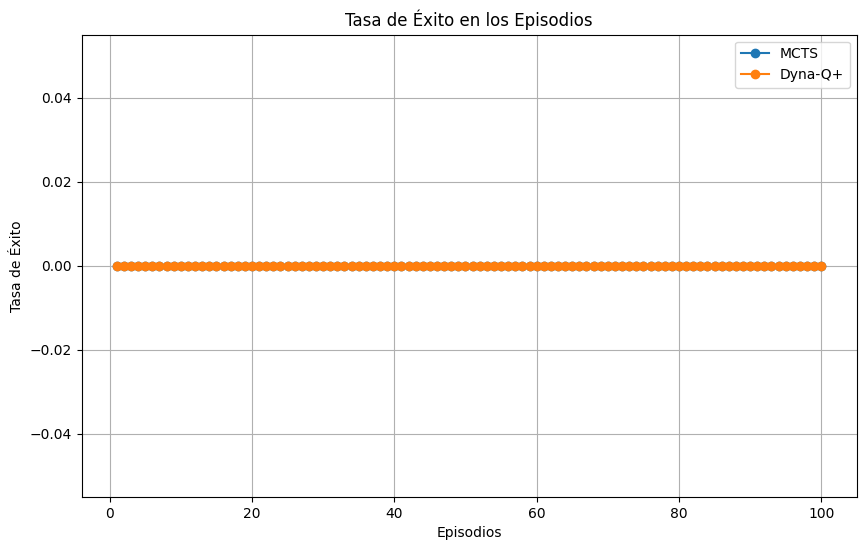

In [48]:
# Gráfico 1: Tasa de éxito en los episodios
plt.figure(figsize=(10, 6))
plt.plot(episodes, success_rate_mcts, label='MCTS', marker='o')
plt.plot(episodes, success_rate_dynaq, label='Dyna-Q+', marker='o')
plt.title('Tasa de Éxito en los Episodios')
plt.xlabel('Episodios')
plt.ylabel('Tasa de Éxito')
plt.legend()
plt.grid(True)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (100,) and (1000,)

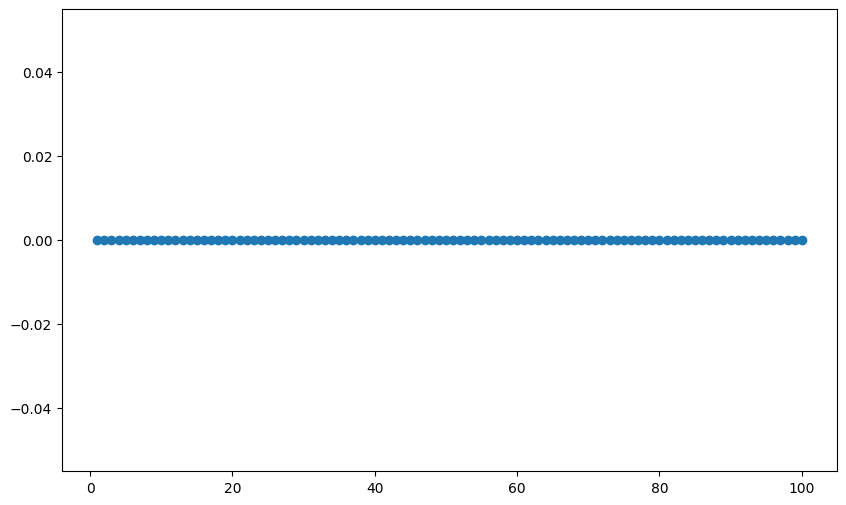

In [49]:
# Gráfico 2: Recompensa promedio por episodio
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards_mcts, label='MCTS', marker='o')
plt.plot(episodes, rewards_dynaq, label='Dyna-Q+', marker='o')
plt.title('Recompensa Promedio por Episodio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.legend()
plt.grid(True)
plt.show()

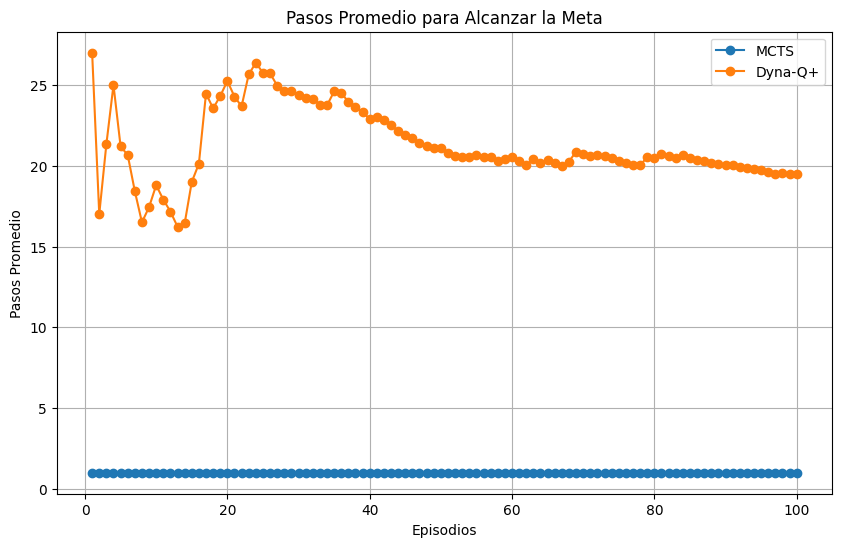

In [50]:
# Gráfico 3: Tasa de convergencia (pasos promedio por episodio)
steps_mcts_avg = [sum(steps_mcts[:i+1]) / (i + 1) for i in range(len(episodes))]
steps_dynaq_avg = [sum(steps_dynaq[:i+1]) / (i + 1) for i in range(len(episodes))]

plt.figure(figsize=(10, 6))
plt.plot(episodes, steps_mcts_avg, label='MCTS', marker='o')
plt.plot(episodes, steps_dynaq_avg, label='Dyna-Q+', marker='o')
plt.title('Pasos Promedio para Alcanzar la Meta')
plt.xlabel('Episodios')
plt.ylabel('Pasos Promedio')
plt.legend()
plt.grid(True)
plt.show()

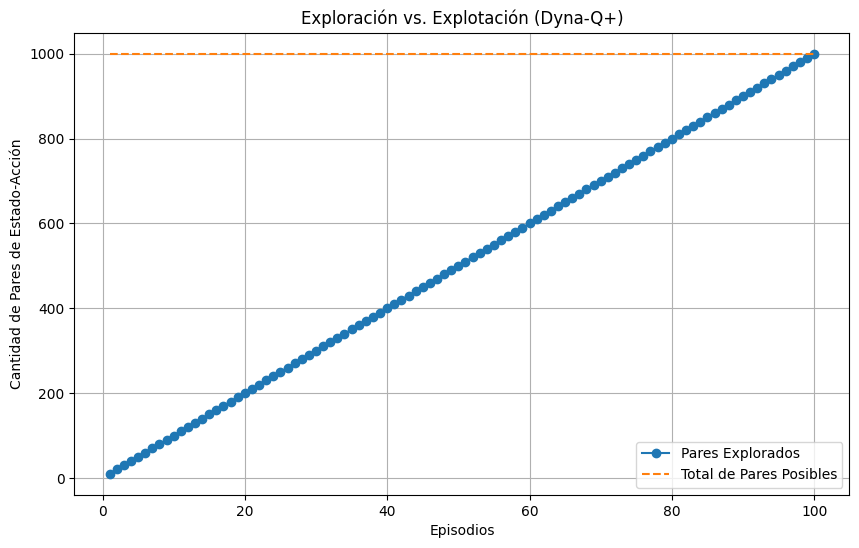

In [51]:
# Gráfico 4: Exploración vs. Explotación para Dyna-Q+
explored_pairs = [i*10 for i in range(1, 101)] 
total_pairs = [1000 for _ in range(100)] 

plt.figure(figsize=(10, 6))
plt.plot(episodes, explored_pairs, label='Pares Explorados', marker='o')
plt.plot(episodes, total_pairs, label='Total de Pares Posibles', linestyle='--')
plt.title('Exploración vs. Explotación (Dyna-Q+)')
plt.xlabel('Episodios')
plt.ylabel('Cantidad de Pares de Estado-Acción')
plt.legend()
plt.grid(True)
plt.show()


#### 5. Análisis:
Compare los resultados de MCTS y Dyna-Q+.

**b. Analice las fortalezas y debilidades de cada enfoque en el contexto de FrozenLake-v1.**


**c. Considere el impacto de la naturaleza estocástica del entorno en el rendimiento de ambos algoritmos.**